# SPH6004 Assignment1 Huang Zefan A0149880R E0014784

## headers and imports

In [1]:
#general imports
import numpy as np
import pandas as pd
import time

#data processing imports
from sklearn.impute import SimpleImputer

#feature selection imports
from sklearn.model_selection import train_test_split
from genetic_selection import GeneticSelectionCV

#learning imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

#metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay

#plotting figure imports
import matplotlib.pyplot as plt
import seaborn as sns


## data preprocessing

we have to deal with data that is imperfect and unsuitable for use in training. the following steps are taken

1. dealing with data with subpar quality
  * filtering out data that does not lie within sensible ranges (bad entry)
  * removing patient entries with large percentage of fields empty (poor entry)
  * removing fields with large percentage of missing patient entries (poor field)
2. transforming data for training
  * encoding categories into numerical values as model inputs (binary, multiple categories)
  * imputing values to replace NaNs
  * normalizing data to deal with different ranges
  

### dealing with subpar data quality

In [2]:
data = pd.read_csv("./data.csv")
print(data.shape)

data.aki.value_counts()

(50920, 162)


aki
0    16860
2    16288
1     9838
3     7934
Name: count, dtype: int64

In [3]:
#get data ranges
col_max = data.max()
col_min = data.min()
col_range = pd.concat([col_min, col_max], axis = 1)
col_range.columns = ["min", "max"]
print(col_range.to_string())

                                                  min              max
id                                           30000153         39999810
aki                                                 0                3
gender                                              F                M
admission_age                               18.002527       102.865603
race                    AMERICAN INDIAN/ALASKA NATIVE  WHITE - RUSSIAN
heart_rate_min                                    1.0            167.0
heart_rate_max                                   36.0            280.0
heart_rate_mean                                  28.5       174.740741
sbp_min                                         0.108            195.0
sbp_max                                          34.0            357.0
sbp_mean                                         32.0       215.857143
dbp_min                                           1.0            113.0
dbp_max                                          17.0            291.0
dbp_me

anomalous inputs such as: glucodse_min, glucose_max, glucose_mean and weight_admit to be filtered out

150.3344393519077 6340.018017427811
19170.38849163534
True


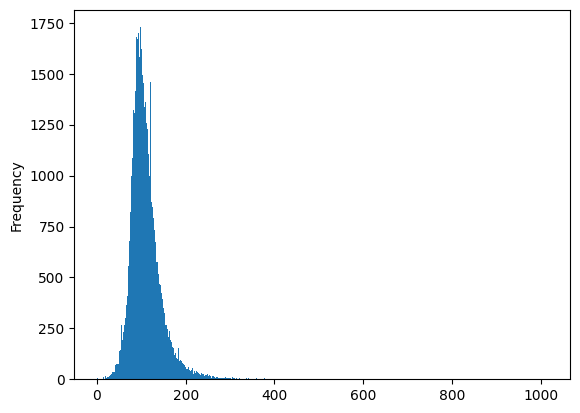

In [4]:
#helper func to viz specified data field e.g. glucose_min

plot_var_name = "glucose_min"
plot_var_data = data[plot_var_name].copy()
print(plot_var_data.mean(), plot_var_data.std())
plot_var_data_max = plot_var_data.mean() + (plot_var_data.std() * 3)
print(plot_var_data_max)
plot_var_data[plot_var_data > plot_var_data_max] = np.nan
plot_var_data.plot.hist(bins=500)

#check whether majority of admissable data has been captured
print(plot_var_data_max > plot_var_data.max())

In [5]:
#do previous cell in place over identified fields
anomalous_data_fields = ["glucose_min", "glucose_max", "glucose_mean", "weight_admit"]
for field in anomalous_data_fields:
    field_data = data[field]
    field_data_mean = field_data.mean()
    field_data_std = field_data.std()
    field_data_range = [field_data_mean - 3 * field_data_std, field_data_mean + 3 * field_data_std]
    data.loc[(field_data < field_data_range[0]) | (field_data > field_data_range[1])] = np.nan
    print(field, field_data.min(), field_data.min() > field_data_range[0], field_data.max(), field_data.max() < field_data_range[1])

glucose_min 0.12 True 1016.0 True
glucose_max 34.0 True 2440.0 True
glucose_mean 34.0 True 279.2 True
weight_admit 1.0 True 190.3 True


check quality of each data input for missing fields per patient

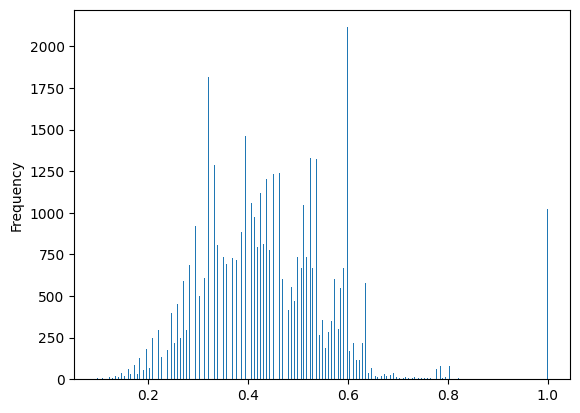

In [6]:
null_entry_count = data.isna().sum(axis = 1)
num_col = len(data.columns)
null_entry_count_percent = null_entry_count/num_col
plot = null_entry_count_percent.plot.hist(bins=500)

In [7]:
#try removing invalid data
null_entry_remove = data.copy()
null_entry_remove = null_entry_remove.dropna()
len(null_entry_remove)

#aaaaand finding out there is not a single entry with no invalid data :(

0

deciding to take 80% threshold for completeness of a patient's total fields as a high-pass threshold for usability of data.

In [8]:
data = data.dropna(axis = 0, thresh = len(data.columns) * 0.8)
len(data)

688

688 entries remaining after removing low-quality entries

now to check quality of features for the remaining entries

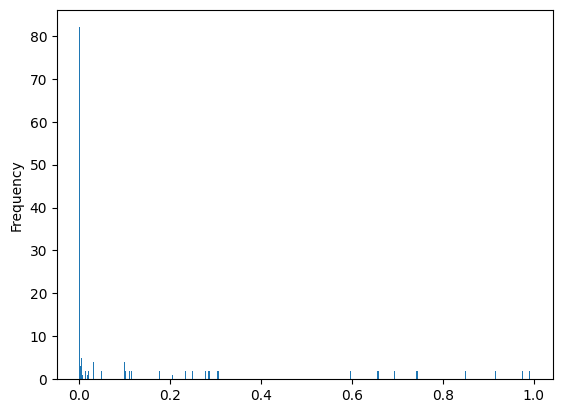

In [9]:
null_feature_count = data.isna().sum(axis = 0)
num_row = len(data.index)
null_feature_count_percent = null_feature_count/num_row
plot = null_feature_count_percent.plot.hist(bins=500)

deciding to take 80% as threshold for completeness of a feature for usability of data 

In [10]:
data = data.dropna(axis = 1, thresh = len(data.index) * 0.8)
data = data.drop("id", axis=1)

len(data.columns)

118

100 features remaining with more than 80% completeness chosen

Final data size is 688 * 118

In [11]:
print(data.shape)
#features remaining
for col in data.columns:
    print(col)
data


(688, 118)
aki
gender
admission_age
race
heart_rate_min
heart_rate_max
heart_rate_mean
sbp_min
sbp_max
sbp_mean
dbp_min
dbp_max
dbp_mean
mbp_min
mbp_max
mbp_mean
resp_rate_min
resp_rate_max
resp_rate_mean
temperature_min
temperature_max
temperature_mean
spo2_min
spo2_max
spo2_mean
glucose_min
glucose_max
glucose_mean
lactate_min
lactate_max
ph_min
ph_max
so2_min
so2_max
po2_min
po2_max
pco2_min
pco2_max
aado2_calc_min
aado2_calc_max
pao2fio2ratio_min
pao2fio2ratio_max
baseexcess_min
baseexcess_max
totalco2_min
totalco2_max
hematocrit_min
hematocrit_max
hemoglobin_min
hemoglobin_max
chloride_min
chloride_max
calcium_min
calcium_max
glucose_min.1
glucose_max.1
potassium_min
potassium_max
sodium_min
sodium_max
hematocrit_min.1
hematocrit_max.1
hemoglobin_min.1
hemoglobin_max.1
platelets_min
platelets_max
wbc_min
wbc_max
albumin_min
albumin_max
aniongap_min
aniongap_max
bicarbonate_min.1
bicarbonate_max.1
bun_min
bun_max
calcium_min.1
calcium_max.1
chloride_min.1
chloride_max.1
glucose_min

,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,...,ast_min,ast_max,bilirubin_total_min,bilirubin_total_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,weight_admit
129,3.0,F,20.909196,OTHER,94.0,136.0,115.031250,31.0,156.0,113.062500,...,83.0,152.0,1.9,2.5,15.0,6.0,5.0,4.0,0.0,95.5
270,3.0,M,28.544966,WHITE,59.0,86.0,75.487179,73.0,141.0,115.583333,...,1660.0,2082.0,0.4,0.7,15.0,1.0,0.0,1.0,1.0,100.0
289,3.0,F,55.870361,WHITE,95.0,111.0,99.636364,108.0,199.0,147.578947,...,43.0,59.0,0.4,0.6,14.0,6.0,4.0,4.0,0.0,190.0
324,3.0,M,69.752532,UNKNOWN,64.0,110.0,85.196970,67.0,152.0,108.303030,...,186.0,276.0,0.3,0.7,15.0,6.0,0.0,3.0,1.0,80.0
366,1.0,F,74.883919,WHITE,46.0,70.0,61.958333,100.5,179.0,135.791667,...,38.0,38.0,0.4,0.4,15.0,1.0,0.0,1.0,1.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50728,1.0,M,52.430798,UNKNOWN,100.0,139.0,116.444444,78.0,156.0,115.435484,...,66.0,86.0,1.1,3.5,13.0,6.0,4.0,3.0,0.0,93.6
50746,1.0,F,57.976938,UNKNOWN,87.0,126.0,106.160000,94.0,161.0,122.720000,...,25.0,36.0,0.2,0.5,11.0,6.0,2.0,3.0,0.0,71.8
50758,1.0,M,64.966034,WHITE,63.0,84.0,73.419355,92.0,117.0,105.806452,...,49.0,49.0,0.2,0.2,15.0,1.0,0.0,1.0,1.0,67.5
50891,2.0,F,68.097968,UNABLE TO OBTAIN,63.0,93.0,80.869565,95.0,168.0,128.413043,...,22.0,22.0,0.4,0.4,15.0,1.0,0.0,1.0,1.0,100.0


### encode categories, clean up NANs, and normalizing 

from observation only categorical data columns are gender and race

In [12]:
print(data.gender.unique())
print(data.race.unique())

['F' 'M']
['OTHER' 'WHITE' 'UNKNOWN' 'HISPANIC/LATINO - PUERTO RICAN'
 'ASIAN - CHINESE' 'BLACK/CARIBBEAN ISLAND' 'BLACK/AFRICAN AMERICAN'
 'WHITE - OTHER EUROPEAN' 'BLACK/AFRICAN' 'HISPANIC/LATINO - MEXICAN'
 'UNABLE TO OBTAIN' 'ASIAN' 'HISPANIC/LATINO - DOMINICAN'
 'BLACK/CAPE VERDEAN' 'HISPANIC OR LATINO' 'HISPANIC/LATINO - COLUMBIAN'
 'PATIENT DECLINED TO ANSWER' 'WHITE - RUSSIAN'
 'HISPANIC/LATINO - HONDURAN' 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
 'PORTUGUESE' 'ASIAN - SOUTH EAST ASIAN'
 'HISPANIC/LATINO - CENTRAL AMERICAN' 'HISPANIC/LATINO - CUBAN'
 'WHITE - EASTERN EUROPEAN' 'MULTIPLE RACE/ETHNICITY']


There are some unusable data in race category with 'UNKNOWN', 'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER' that should be discarded as well

Will be classifying aki into a binary class as well, with False or 0 included classes of {0} and True or 1 to represent classes of {1, 2, 3}


In [13]:
def encode_aki(aki):
    return 0 if aki == 0 else 1

def encode_gender(gender):
    return 0 if gender == "F" else 1

def encode_race(race):
    if "UNKNOWN" in race or "UNABLE TO OBTAIN" in race or "PATIENT DECLINED TO ANSWER" in race:
        return 0
    if "BLACK" in race:
        return 1
    if "WHITE" in race:
        return 2
    if "ASIAN" in race:
        return 3
    if "HISPANIC" in race:
        return 4
    if "NATIVE" in race:
        return 5
    else: #for all others
        return 6

data_category = pd.DataFrame()
data_category["gender"] = data.gender.map(encode_gender)
data = data.drop("gender", axis = 1)
data_category["aki_bin"] = data.aki.map(encode_aki)
data_category["aki"] = data.aki.copy()
data = data.drop("aki", axis = 1)

data_category["race_unknown"] = (data.race.map(encode_race) == 0).astype(int)
data_category["race_black"] = (data.race.map(encode_race) == 1).astype(int)
data_category["race_white"] = (data.race.map(encode_race) == 2).astype(int)
data_category["race_asian"] = (data.race.map(encode_race) == 3).astype(int)
data_category["race_hispanic"] = (data.race.map(encode_race) == 4).astype(int)
data_category["race_native"] = (data.race.map(encode_race) == 5).astype(int)
data_category["race_other"] = (data.race.map(encode_race) == 6).astype(int)
data = data.drop("race", axis = 1)
data_category


,gender,aki_bin,aki,race_unknown,race_black,race_white,race_asian,race_hispanic,race_native,race_other
129,0,1,3.0,0,0,0,0,0,0,1
270,1,1,3.0,0,0,1,0,0,0,0
289,0,1,3.0,0,0,1,0,0,0,0
324,1,1,3.0,1,0,0,0,0,0,0
366,0,1,1.0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
50728,1,1,1.0,1,0,0,0,0,0,0
50746,0,1,1.0,1,0,0,0,0,0,0
50758,1,1,1.0,0,0,1,0,0,0,0
50891,0,1,2.0,1,0,0,0,0,0,0


cleaning up nans via imputing using sklearn.impute.SimpleImputer

In [14]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(data)
columns = data.columns
data_numerical = pd.DataFrame(imputer.transform(data), columns = columns)
data_numerical

,admission_age,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,...,ast_min,ast_max,bilirubin_total_min,bilirubin_total_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,weight_admit
0,20.909196,94.0,136.0,115.031250,31.0,156.0,113.062500,20.0,104.0,66.187500,...,83.0,152.0,1.9,2.5,15.0,6.0,5.0,4.0,0.0,95.5
1,28.544966,59.0,86.0,75.487179,73.0,141.0,115.583333,51.0,89.0,74.226190,...,1660.0,2082.0,0.4,0.7,15.0,1.0,0.0,1.0,1.0,100.0
2,55.870361,95.0,111.0,99.636364,108.0,199.0,147.578947,46.0,128.0,65.894737,...,43.0,59.0,0.4,0.6,14.0,6.0,4.0,4.0,0.0,190.0
3,69.752532,64.0,110.0,85.196970,67.0,152.0,108.303030,46.0,86.0,64.772727,...,186.0,276.0,0.3,0.7,15.0,6.0,0.0,3.0,1.0,80.0
4,74.883919,46.0,70.0,61.958333,100.5,179.0,135.791667,20.0,47.0,33.104167,...,38.0,38.0,0.4,0.4,15.0,1.0,0.0,1.0,1.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,52.430798,100.0,139.0,116.444444,78.0,156.0,115.435484,41.0,134.0,63.193548,...,66.0,86.0,1.1,3.5,13.0,6.0,4.0,3.0,0.0,93.6
684,57.976938,87.0,126.0,106.160000,94.0,161.0,122.720000,57.0,90.0,70.240000,...,25.0,36.0,0.2,0.5,11.0,6.0,2.0,3.0,0.0,71.8
685,64.966034,63.0,84.0,73.419355,92.0,117.0,105.806452,50.0,76.0,66.645161,...,49.0,49.0,0.2,0.2,15.0,1.0,0.0,1.0,1.0,67.5
686,68.097968,63.0,93.0,80.869565,95.0,168.0,128.413043,50.0,141.0,69.086957,...,22.0,22.0,0.4,0.4,15.0,1.0,0.0,1.0,1.0,100.0


now normalize normally

In [15]:
data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()
data_category.reset_index(drop=True, inplace=True)
data = pd.concat([data_numerical, data_category], axis = 1, join="inner")
data

,admission_age,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,...,gender,aki_bin,aki,race_unknown,race_black,race_white,race_asian,race_hispanic,race_native,race_other
0,-2.305718,0.909144,0.799067,1.076249,-2.504011,0.256650,0.202519,-1.754452,0.634761,0.542099,...,0,1,3.0,0,0,0,0,0,0,1
1,-1.864083,-0.923298,-1.342736,-1.050038,-0.283678,-0.304576,0.378238,0.826360,-0.018739,1.383293,...,1,1,3.0,0,0,1,0,0,0,0
2,-0.283646,0.961500,-0.271835,0.248465,1.566599,1.865497,2.608540,0.410100,1.680362,0.511463,...,0,1,3.0,0,0,1,0,0,0,0
3,0.519266,-0.661521,-0.314671,-0.527942,-0.600869,0.106990,-0.129247,0.410100,-0.149439,0.394053,...,1,1,3.0,1,0,0,0,0,0,0
4,0.816053,-1.603920,-2.028113,-1.777485,1.170111,1.117196,1.786890,-1.754452,-1.848540,-2.919846,...,0,1,1.0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,-0.482583,1.223277,0.927575,1.152236,-0.019353,0.256650,0.367932,-0.006160,1.941762,0.228802,...,1,1,1.0,1,0,0,0,0,0,0
684,-0.161807,0.542656,0.370706,0.599241,0.826488,0.443725,0.875710,1.325872,0.024827,0.966165,...,0,1,1.0,1,0,0,0,0,0,0
685,0.242426,-0.713876,-1.428408,-1.161226,0.720758,-1.202537,-0.303275,0.743108,-0.585106,0.589990,...,1,1,1.0,0,0,1,0,0,0,0
686,0.423570,-0.713876,-1.042884,-0.760627,0.879353,0.705630,1.272552,0.743108,2.246729,0.845507,...,0,1,2.0,1,0,0,0,0,0,0


now we are ready to conduct feature selection

## feature selection

as observed from data fields, there are many fields with similar characteristic such as property_min, property_max and property_mean. we first have to identify and drop features that have high degree of correlation to control the effects of multiple correlated fields affecting the estimator

different features maybe useful for different estimation, an generic function that is agnostic to different estimators needs to be built to select and return the features to be used in the estimator. a genetic selection function from sklearn-genetic will be selected (huehuehue)

### removing highly correlated fields

In [16]:
y_bin = data.aki_bin.copy().to_frame()
y_cat = data.aki.copy().to_frame()
x = data.copy()
x = x.drop("aki", axis = 1)
x = x.drop("aki_bin", axis = 1)

figure out AKI split between positive and negative

In [17]:
print(y_bin.value_counts())
print(y_cat.value_counts())

aki_bin
1          613
0           75
Name: count, dtype: int64
aki
3.0    349
2.0    176
1.0     88
0.0     75
Name: count, dtype: int64


now to split between training and test sets

In [18]:
x_bin_train, x_bin_test, y_bin_train, y_bin_test = train_test_split(x, y_bin, test_size=0.3, random_state=666)
x_cat_train, x_cat_test, y_cat_train, y_cat_test = train_test_split(x, y_cat, test_size=0.3, random_state=666)

check self correlation to get rid of non differentiating features

(481, 123)
(123, 123)


<Axes: >

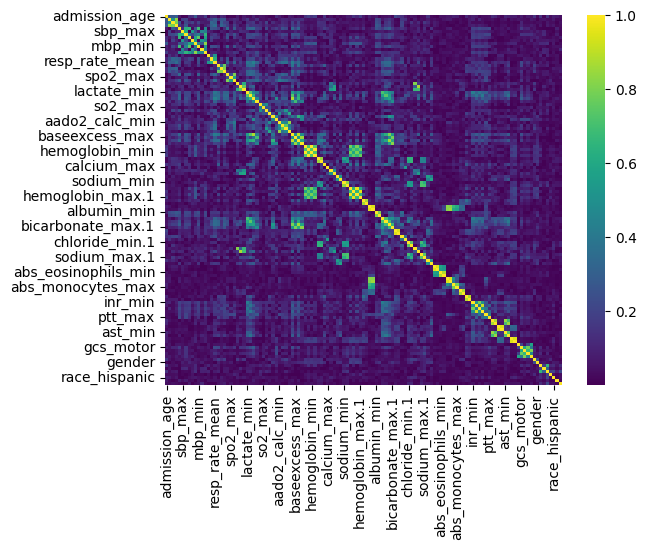

In [19]:
is_bin = True

if is_bin == True:
    x_train = x_bin_train
    x_test = x_bin_test
    y_train = y_bin_train
    y_test = y_bin_test
else:
    x_train = x_cat_train
    x_test = x_cat_test
    y_train = y_cat_train
    y_test = y_cat_test

print(x_train.shape)

x_corr = x.corr().abs()
print(x_corr.shape)
sns.heatmap(x_corr, cmap = "viridis")

In [20]:
x_corr = x_corr[x_corr != 1.00].abs()

print(x_corr.shape)
x_corr_stack = x_corr.stack()
print(len(x_corr_stack))
x_corr_stack = x_corr_stack.drop_duplicates()
print(len(x_corr_stack))
x_corr_stack = x_corr_stack[x_corr_stack > 0.5]
print(len(x_corr_stack))

high_corr_features_pairs = list(x_corr_stack.index)
high_corr_features_uniques = []
high_corr_features = []

#get one feature out of a group with high correlation to each other
for pair in high_corr_features_pairs:
    first, second = pair
    if second == None:
        continue
    if first not in high_corr_features_uniques and second not in high_corr_features_uniques:
        high_corr_features.append(first)
        high_corr_features_uniques.append(first)
        high_corr_features_uniques.append(second)
    elif first not in high_corr_features_uniques:
        high_corr_features_uniques.append(first)
    elif second not in high_corr_features_uniques:
        high_corr_features_uniques.append(second)
    else:
        continue
for feature in high_corr_features_uniques:
    if feature not in high_corr_features and "race" in feature:
        high_corr_features.append(feature)

features_to_drop = [feature for feature in high_corr_features_uniques if feature not in high_corr_features]
print(len(features_to_drop), features_to_drop)
# x_train = x_train.drop(columns=features_to_drop)
# x_test = x_test.drop(columns=features_to_drop)
# Disabled self correlation filtering for better performance due to low number of candidate features

(123, 123)
15006
7503
170
79 ['heart_rate_max', 'heart_rate_mean', 'sbp_mean', 'dbp_min', 'mbp_min', 'sbp_max', 'dbp_max', 'mbp_mean', 'dbp_mean', 'resp_rate_mean', 'resp_rate_max', 'temperature_mean', 'temperature_max', 'spo2_mean', 'spo2_max', 'glucose_mean', 'glucose_min.2', 'glucose_max', 'glucose_max.1', 'glucose_max.2', 'glucose_min.1', 'lactate_max', 'baseexcess_min', 'totalco2_min', 'aniongap_min', 'aniongap_max', 'bicarbonate_min.1', 'ph_min', 'baseexcess_max', 'po2_min', 'pao2fio2ratio_min', 'pao2fio2ratio_max', 'pco2_min', 'aado2_calc_min', 'aado2_calc_max', 'bicarbonate_max.1', 'totalco2_max', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max', 'hematocrit_min.1', 'hematocrit_max.1', 'hemoglobin_min.1', 'hemoglobin_max.1', 'chloride_max', 'sodium_min', 'chloride_min.1', 'chloride_max.1', 'sodium_max', 'calcium_max.1', 'potassium_max', 'potassium_min.1', 'potassium_max.1', 'sodium_min.1', 'sodium_max.1', 'platelets_max', 'wbc_max', 'abs_lymphocytes_min', 'abs_lymphocytes_m

In [21]:
x_train.shape

(481, 123)

we have narrowed down to 41 distinct features that can be now used as candidate features to be selected for use in our estimator models

manual pre-processing done

#### feature selection function and training functions

In [22]:
def feature_select(model_name, classifier, dataset):
    x_train, y_train = dataset
    #parameters for genetic selection
    n_population = 100
    crossover_proba = 0.8
    mutation_proba = 0.2
    n_generations = 5
    tournament_size = 10

    feature_selector = GeneticSelectionCV(
        classifier,
        cv=10,
        scoring="accuracy",
        n_jobs=-1,
        n_population=n_population,
        crossover_proba=crossover_proba,
        mutation_proba=mutation_proba,
        crossover_independent_proba=0.5,
        mutation_independent_proba=0.05,
        n_generations=n_generations,
        tournament_size=tournament_size,
        n_gen_no_change=5,
        caching=True,
    )

    start_time = time.time()
    feature_selector = feature_selector.fit(x_train, y_train.values.ravel())
    time_taken = time.time() - start_time
    features_selected_bool = feature_selector.support_
    features_selected = x_train.columns[features_selected_bool]
    print(model_name, "Time Taken for Feature Selection:", round(time_taken, 1), "seconds")
    print("Selected Features:", features_selected)
    return features_selected

In [23]:
#function for training and pretty printing training and test scores
def train(model_name, classifier, dataset):
    train, test = dataset
    x_train, y_train = train
    x_test, y_test = test

    start_time = time.time()

    #start test
    classifier = classifier.fit(x_train, y_train.values.ravel())
    y_train_prediction =  classifier.predict(x_train)
    y_test_prediction = classifier.predict(x_test)

    time_taken = time.time() - start_time

    #metrics for training set
    f1_score_train = accuracy_score(y_train, y_train_prediction)
    auroc_train = roc_auc_score(y_train, y_train_prediction)

    #metrics for test set
    f1_score_test = accuracy_score(y_test, y_test_prediction)
    auroc_test = roc_auc_score(y_test, y_test_prediction)

    print(model_name, "Training Scores - F1:", round(f1_score_train, 3), "and AUROC: ", round(auroc_train, 3))
    print(model_name, "Test Scores - F1:", round(f1_score_test, 3), "and AUROC: ", round(auroc_test, 3))
    print(model_name, "Time Taken for Training:", round(time_taken, 1), "seconds")
    return auroc_train, auroc_test, f1_score_train, f1_score_test, classifier, y_test_prediction, y_train_prediction

    


## Feature and Model Selection with Parameter Sweep

with feature selection function, models for training can be established

classification models that were went thru in SPH6004 includes {Logistic Regression, Decision Tree, Random Forest, Adaboost, Gradient Boost, SVM}

to enable finding of the best estimator for different models, we will setup parameter sweeps to undergo a process of trial and error, A FAMOUS MACHINE LEARNING TECHNIQUE, to help with finding the best possible model with parameter combination 

In [24]:
#setup models and parameter sweeps

#default values

model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "Adaboost", "Gradient Boost", "Support Vector Machine"]

# for debugging
# model_names = ["Logistic Regression", "Decision Tree"]

models = {
    "Logistic Regression": LogisticRegression(solver="liblinear"),
    "Decision Tree": DecisionTreeClassifier(criterion="entropy"),
    "Random Forest": RandomForestClassifier(),
    "Adaboost": AdaBoostClassifier(),
    "Gradient Boost": GradientBoostingClassifier(),
    "Support Vector Machine": SVC()
}

#param sweep values
logistic_regression_params = {"C": [0.1, 1, 10, 100], "penalty": ["l1", "l2"]}
decision_tree_params = {"max_depth":[3, 5, 7]}
random_forest_params = {"max_depth":[3, 5, 7], "n_estimators": [50, 100, 500], "max_samples": [100, 1000, 3515]}
adaboost_params = {"learning_rate": [0.001, 0.01, 0.1], "n_estimators": [10, 50 , 100, 500], "estimator": [DecisionTreeClassifier(max_depth= 3, class_weight = "balanced"), DecisionTreeClassifier(max_depth= 5, class_weight= "balanced"), DecisionTreeClassifier(max_depth= 7, class_weight= "balanced")]}
gradient_boost_params = {"learning_rate": [0.001, 0.01, 0.1, 1], "n_estimators": [10, 50, 100, 500, 1000], 'subsample': [0.5, 0.7, 1.0], 'max_depth': [3, 5, 7]}
svm_params = {"C":[100, 10, 1.0, 0.1, 0.01] , "kernel":["linear", "poly", "rbf", "sigmoid"]}

#setup param grid for grid search
param_grid = {
    "Logistic Regression": [logistic_regression_params],
    "Decision Tree": [decision_tree_params],
    "Random Forest": [random_forest_params],
    "Adaboost": [adaboost_params],
    "Gradient Boost": [gradient_boost_params],
    "Support Vector Machine": [svm_params]
}



In [25]:
#run baseline test

total_start_time = time.time()

classifiers_baseline = {}
auroc_train_baseline = {}
auroc_test_baseline = {}
prediction_baseline = {}
f1_train_baseline = {}
f1_test_baseline = {}

for model_name in model_names:
    print ("###########################\t", model_name, "Baseline", " "*(25-len(model_name)), "###########################")
    model = models[model_name]
    dataset = [[x_train, y_train], [x_test, y_test]]
    auroc_train, auroc_test, f1_score_train, f1_score_test, classifier, prediction_test, prediction_train = train(model_name, model, dataset)

    classifiers_baseline[model_name] = classifier
    auroc_train_baseline[model_name] = auroc_train
    auroc_test_baseline[model_name] = auroc_test
    prediction_baseline[model_name] = [prediction_test, prediction_train]
    f1_train_baseline[model_name] = f1_score_train
    f1_test_baseline[model_name] = f1_score_test



###########################	 Logistic Regression Baseline        ###########################
Logistic Regression Training Scores - F1: 0.973 and AUROC:  0.883
Logistic Regression Test Scores - F1: 0.865 and AUROC:  0.582
Logistic Regression Time Taken for Training: 0.0 seconds
###########################	 Decision Tree Baseline              ###########################
Decision Tree Training Scores - F1: 1.0 and AUROC:  1.0
Decision Tree Test Scores - F1: 0.855 and AUROC:  0.595
Decision Tree Time Taken for Training: 0.0 seconds
###########################	 Random Forest Baseline              ###########################
Random Forest Training Scores - F1: 1.0 and AUROC:  1.0
Random Forest Test Scores - F1: 0.894 and AUROC:  0.522
Random Forest Time Taken for Training: 0.3 seconds
###########################	 Adaboost Baseline                   ###########################
Adaboost Training Scores - F1: 1.0 and AUROC:  1.0
Adaboost Test Scores - F1: 0.879 and AUROC:  0.59
Adaboost Time Ta

In [26]:
#run feature selection

classifiers_feature = {}
features_selected = {}
auroc_train_feature = {}
auroc_test_feature = {}
prediction_feature = {}
f1_train_feature = {}
f1_test_feature = {}

for model_name in model_names:
    print ("###########################\t", model_name, "Feature Selection", " "*(25-len(model_name)), "###########################")
    training_set = [x_train, y_train]
    model = classifiers_baseline[model_name]
    features = feature_select(model_name, model, training_set)

    x_train_features = x_train[features]
    x_test_features = x_test[features]
    training_set_features = [x_train_features, y_train]
    test_set_features = [x_test_features, y_test]
    dataset_features = [training_set_features, test_set_features]
    auroc_train, auroc_test, f1_score_train, f1_score_test, classifier, prediction_test, prediction_train = train(model_name, model, dataset_features)

    classifiers_feature[model_name] = classifier
    features_selected[model_name] = features
    auroc_train_feature[model_name] = auroc_train
    auroc_test_feature[model_name] = auroc_test
    prediction_feature[model_name] = [prediction_test, prediction_train]
    f1_test_feature[model_name] = f1_score_test
    f1_train_feature[model_name] = f1_score_train

###########################	 Logistic Regression Feature Selection        ###########################
Logistic Regression Time Taken for Feature Selection: 2.8 seconds
Selected Features: Index(['sbp_max', 'sbp_mean', 'dbp_min', 'mbp_min', 'spo2_min', 'spo2_max',
       'glucose_max', 'lactate_min', 'ph_max', 'so2_min', 'po2_min',
       'pco2_min', 'pco2_max', 'aado2_calc_min', 'baseexcess_min',
       'baseexcess_max', 'hemoglobin_min', 'glucose_min.1', 'sodium_min',
       'hematocrit_min.1', 'platelets_max', 'bicarbonate_max.1', 'bun_min',
       'bun_max', 'calcium_min.1', 'glucose_min.2', 'glucose_max.2',
       'sodium_min.1', 'abs_lymphocytes_min', 'abs_lymphocytes_max',
       'abs_monocytes_min', 'abs_neutrophils_min', 'abs_neutrophils_max',
       'inr_max', 'pt_max', 'ptt_min', 'alp_max', 'gcs_motor', 'gcs_eyes',
       'weight_admit', 'race_asian'],
      dtype='object')
Logistic Regression Training Scores - F1: 0.938 and AUROC:  0.72
Logistic Regression Test Scores - F1: 0

In [27]:
classifiers_optimized = {}
auroc_train_optimized = {}
auroc_test_optimized = {}
prediction_optimized = {}
f1_train_optimized = {}
f1_test_optimized = {}

for model_name in model_names:
    print ("###########################\t", model_name, "Grid Search", " "*(25-len(model_name)), "###########################")
    model = classifiers_feature[model_name]
    features = features_selected[model_name]
    x_train_features = x_train[features]
    x_test_features = x_test[features]
    training_set_features = [x_train_features, y_train]
    test_set_features = [x_test_features, y_test]
    dataset_optimization = [training_set_features, test_set_features]

    grid_search_classifier = GridSearchCV(model, param_grid[model_name], cv = 10, scoring='roc_auc', n_jobs=-1)

    auroc_train, auroc_test, f1_score_train, f1_score_test, classifier, prediction_test, prediction_train = train(model_name, grid_search_classifier, dataset_features)
    print("Best Parameters for", model_name,":", classifier.best_params_)
    
    classifiers_optimized[model_name] = classifier
    auroc_train_optimized[model_name] = auroc_train
    auroc_test_optimized[model_name] = auroc_test
    prediction_optimized[model_name] = [prediction_test, prediction_train]
    f1_train_optimized[model_name] = f1_score_train
    f1_test_optimized[model_name] = f1_score_test

###########################	 Logistic Regression Grid Search        ###########################
Logistic Regression Training Scores - F1: 0.892 and AUROC:  0.5
Logistic Regression Test Scores - F1: 0.889 and AUROC:  0.5
Logistic Regression Time Taken for Training: 1.2 seconds
Best Parameters for Logistic Regression : {'C': 10, 'penalty': 'l1'}
###########################	 Decision Tree Grid Search              ###########################
Decision Tree Training Scores - F1: 0.904 and AUROC:  0.575
Decision Tree Test Scores - F1: 0.889 and AUROC:  0.5
Decision Tree Time Taken for Training: 0.1 seconds
Best Parameters for Decision Tree : {'max_depth': 3}
###########################	 Random Forest Grid Search              ###########################


/home/ziggy/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
180 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ziggy/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ziggy/.local/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/ziggy/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 408, in fit
    n_samples_bootstrap = _get_n_samples_bootstrap(
  

Random Forest Training Scores - F1: 0.892 and AUROC:  0.5
Random Forest Test Scores - F1: 0.889 and AUROC:  0.5
Random Forest Time Taken for Training: 2.8 seconds
Best Parameters for Random Forest : {'max_depth': 3, 'max_samples': 100, 'n_estimators': 500}
###########################	 Adaboost Grid Search                   ###########################
Adaboost Training Scores - F1: 0.709 and AUROC:  0.659
Adaboost Test Scores - F1: 0.696 and AUROC:  0.562
Adaboost Time Taken for Training: 14.0 seconds
Best Parameters for Adaboost : {'estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 0.001, 'n_estimators': 10}
###########################	 Gradient Boost Grid Search             ###########################
Gradient Boost Training Scores - F1: 0.892 and AUROC:  0.5
Gradient Boost Test Scores - F1: 0.889 and AUROC:  0.5
Gradient Boost Time Taken for Training: 62.7 seconds
Best Parameters for Gradient Boost : {'learning_rate': 0.001, 'max_depth': 3, 'n

In [28]:
#cmd test
total_time_taken = time.time() - total_start_time
print(total_time_taken)

484.982871055603


Approx runtime is 485s

## Plotting Data

### AUROC Figures

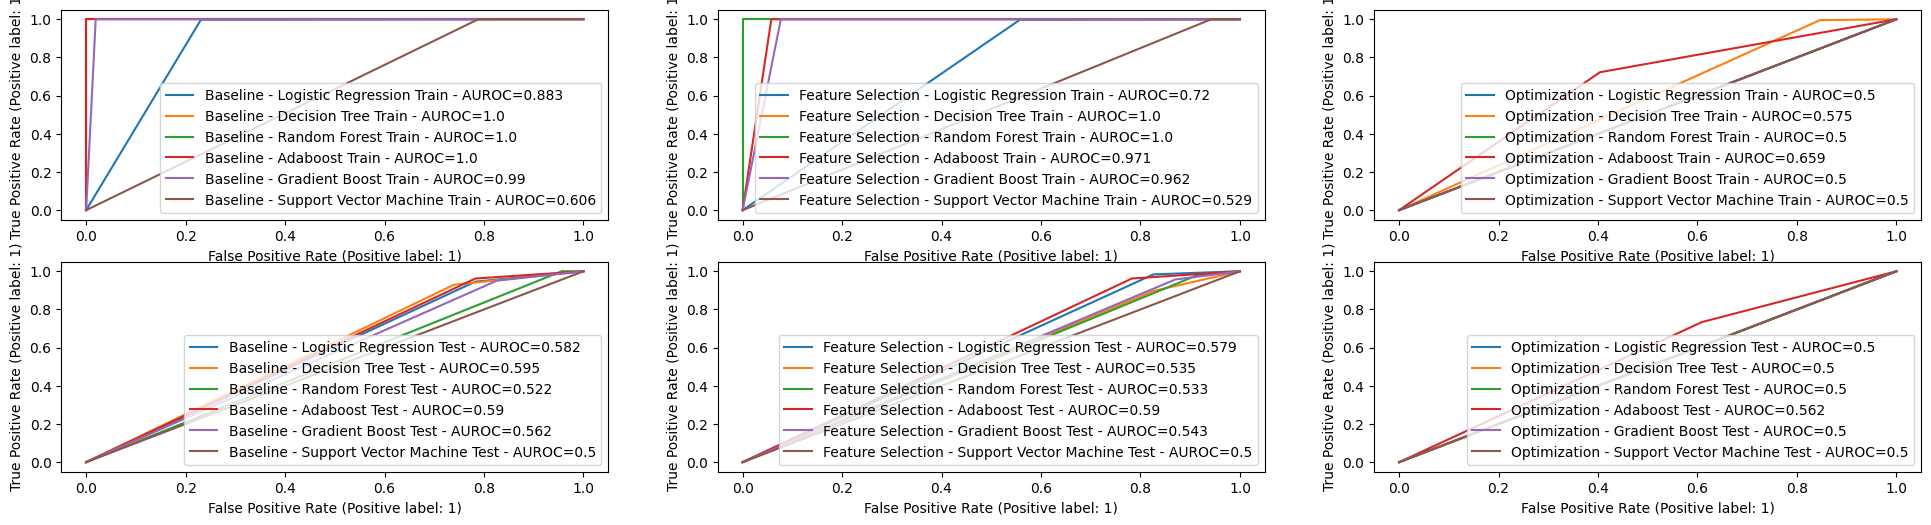

In [34]:


#consolidate data
prediction_results = {"Baseline": prediction_baseline, "Feature Selection": prediction_feature, "Optimization": prediction_optimized}
auroc_train_results = {"Baseline": auroc_train_baseline, "Feature Selection": auroc_train_feature, "Optimization": auroc_train_optimized}
auroc_test_results = {"Baseline": auroc_test_baseline, "Feature Selection": auroc_test_feature, "Optimization": auroc_test_optimized}
f1_test_results = {"Baseline": f1_test_baseline, "Feature Selection": f1_test_feature, "Optimization": f1_test_optimized}
f1_train_results = {"Baseline": f1_train_baseline, "Feature Selection": f1_train_feature, "Optimization": f1_train_optimized}
test_names = ["Baseline", "Feature Selection", "Optimization"]

#plotting AUROC
fig, axs = plt.subplots(2, 3, figsize=(24,6))

for i in range(3):
    test_name = test_names[i]
    prediction_models = prediction_results[test_name]
    auroc_train_models = auroc_train_results[test_name]
    auroc_test_models = auroc_test_results[test_name]
    
    for model_name in model_names:
        prediction_test, prediction_train = prediction_models[model_name]
        auroc_train = auroc_train_models[model_name]
        auroc_test = auroc_test_models[model_name]
        RocCurveDisplay.from_predictions(
            y_true = y_train, 
            y_pred = prediction_train, 
            ax = axs[0][i], 
            label = test_name + " - " + model_name + " Train - AUROC=" + str(round(auroc_train,3))
        )
        RocCurveDisplay.from_predictions(
            y_true = y_test, 
            y_pred = prediction_test, 
            ax = axs[1][i], 
            label = test_name + " - " + model_name + " Test - AUROC=" + str(round(auroc_test,3)) 
        )


### F1 Score Visualization

In [35]:
f1_train_results

{'Baseline': {'Logistic Regression': 0.972972972972973,
  'Decision Tree': 1.0,
  'Random Forest': 1.0,
  'Adaboost': 1.0,
  'Gradient Boost': 0.997920997920998,
  'Support Vector Machine': 0.9147609147609148},
 'Feature Selection': {'Logistic Regression': 0.9376299376299376,
  'Decision Tree': 1.0,
  'Random Forest': 1.0,
  'Adaboost': 0.9937629937629938,
  'Gradient Boost': 0.9916839916839917,
  'Support Vector Machine': 0.8981288981288982},
 'Optimization': {'Logistic Regression': 0.8918918918918919,
  'Decision Tree': 0.9043659043659044,
  'Random Forest': 0.8918918918918919,
  'Adaboost': 0.7089397089397089,
  'Gradient Boost': 0.8918918918918919,
  'Support Vector Machine': 0.8918918918918919}}

In [37]:
f1_test_results

{'Baseline': {'Logistic Regression': 0.8647342995169082,
  'Decision Tree': 0.855072463768116,
  'Random Forest': 0.893719806763285,
  'Adaboost': 0.8792270531400966,
  'Gradient Boost': 0.8647342995169082,
  'Support Vector Machine': 0.8888888888888888},
 'Feature Selection': {'Logistic Regression': 0.893719806763285,
  'Decision Tree': 0.8164251207729468,
  'Random Forest': 0.8792270531400966,
  'Adaboost': 0.8792270531400966,
  'Gradient Boost': 0.8647342995169082,
  'Support Vector Machine': 0.8888888888888888},
 'Optimization': {'Logistic Regression': 0.8888888888888888,
  'Decision Tree': 0.8888888888888888,
  'Random Forest': 0.8888888888888888,
  'Adaboost': 0.6956521739130435,
  'Gradient Boost': 0.8888888888888888,
  'Support Vector Machine': 0.8888888888888888}}

In [32]:
# echo area echo area